<a href="https://colab.research.google.com/github/Juanfra21/nlp-yu/blob/main/NLP_Assignment_4_Juan_Leonhardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 - Juan Leonhardt

In [1]:
import nltk
nltk.download('names')
from nltk.corpus import names
import random
from transformers import BertTokenizer, TFBertForSequenceClassification

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [2]:
import tensorflow as tf
import numpy as np

# Loading the data

In [3]:
# Load data
male_names = names.words('male.txt')
female_names = names.words('female.txt')

# Label the data
male_labels = [(name.lower(), 0) for name in male_names]
female_labels = [(name.lower(), 1) for name in female_names]

# Combine and shuffle
all_names = male_labels + female_labels
random.shuffle(all_names)

# Split data
train_size = int(0.8 * len(all_names))
train_data = all_names[:train_size]
test_data = all_names[train_size:]

train_names, train_labels = zip(*train_data)
test_names, test_labels = zip(*test_data)

In [4]:
print("Training names:", len(train_names))
print("Testing names:", len(test_names))

Training names: 6355
Testing names: 1589


# Transformers Approach

## Preparing BERT input

For this purpose we will choose Bert Uncased, which is the one with the lowest amount of parameters, as the names are already in lowercase, and this is not a complex NLP task.

In [7]:
# We initialize the BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
print(bert_tokenizer.tokenize(train_names[87]))

['doris']


In [9]:
print(bert_tokenizer.tokenize("helen-elizabeth"))

['helen', '-', 'elizabeth']


In [10]:
print(bert_tokenizer.tokenize("jean-francois"))

['jean', '-', 'francois']


We conver tthe names into features from the tokens generateed by the BERT tokenizer

In [11]:
def convert_names_to_feature(name):
  return bert_tokenizer.encode_plus(name,
                add_special_tokens = False,     # We are only classifiying names
                max_length = 15,              # Here we chose a max length of 15, which is a reasonable limit, since names are short
                padding='max_length',
                truncation=True,
                return_attention_mask = True,
              )

Let's see some example of names converted to features

In [12]:
convert_names_to_feature(train_names[87])

{'input_ids': [15467, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [13]:
convert_names_to_feature(train_names[454])

{'input_ids': [15775, 16643, 3723, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [14]:
# We now map to the expected input to TFBertForSequenceClassification
def map_name_to_dict(input_ids, attention_masks, label):
  return {"input_ids": input_ids, "attention_mask": attention_masks}, label

def encode_names(ds):
  # Prepare lists to build the final tensorflow dataset
  input_ids_list = []
  attention_mask_list = []
  label_list = []

  for name, label in ds:
    bert_input = convert_names_to_feature(name)
    input_ids_list.append(bert_input['input_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append(label)

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list)).map(map_name_to_dict)

In [15]:
# Let's define a batch size of 8
batch_size = 8

ds_train = zip(train_names, train_labels)
ds_test = zip(test_names, test_labels)

ds_train_encoded = encode_names(ds_train).shuffle(len(train_names)).batch(batch_size)
ds_test_encoded = encode_names(ds_test).batch(batch_size)

## Model

In [18]:
# Two classes, male and female names
num_classes = 2

# Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Using the recommended learning rate for Adam
learning_rate = 2e-5

# Increase the number of epochs from 4 to 8 in hopes of getting good results
number_of_epochs = 8


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

bert_model.compile(loss=loss, optimizer=optimizer, metrics=metric)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's address class imbalance in the data

In [20]:
import collections

# Check the distribution in training and validation sets
train_labels_counts = collections.Counter(train_labels)
test_labels_counts = collections.Counter(test_labels)

print("Training labels distribution:", train_labels_counts)
print("Validation labels distribution:", test_labels_counts)

Training labels distribution: Counter({1: 3968, 0: 2387})
Validation labels distribution: Counter({1: 1033, 0: 556})


In [21]:
class_weights = {0: 1.0, 1: (len(train_labels) / (2 * collections.Counter(train_labels)[1]))}

In [24]:
class_weights

{0: 1.0, 1: 0.80078125}

Now, we fit the model with the new class weights

In [23]:
history = bert_model.fit(ds_train_encoded,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded,
                         class_weight=class_weights)

Epoch 1/8


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
795/795 [==============================] - 179s 107ms/step - loss: 0.5088 - accuracy: 0.7004 - val_loss: 0.4147 - val_accuracy: 0.8244
Epoch 2/8
795/795 [==============================] - 80s 101ms/step - loss: 0.3682 - accuracy: 0.8225 - val_loss: 0.3419 - val_accuracy: 0.8634
Epoch 3/8
795/795 [==============================] - 78s 98ms/step - loss: 0.2881 - accuracy: 0.8688 - val_loss: 0.3913 - val_accuracy: 0.8521
Epoch 4/8
795/795 [==============================] - 74s 93ms/step - loss: 0.2453 - accuracy: 0.8870 - val_loss: 0.3550 - val_accuracy: 0.8647
Epoch 5/8
795/795 [==============================] - 74s 93ms/step - loss: 0.2101 - accuracy: 0.9053 - val_loss: 0.3764 - val_accuracy: 0.8571
Epoch 6/8
795/795 [==============================] - 77s 97ms/step - loss: 0.1742 - accuracy: 0.9197 - val_loss: 0.3564 - val_accuracy: 0.8546
Epoch 7/8
7

8 epochs seem to have been unnecessary, as the model reached the maximum validation accuracy in the 4th epoch.

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150

# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

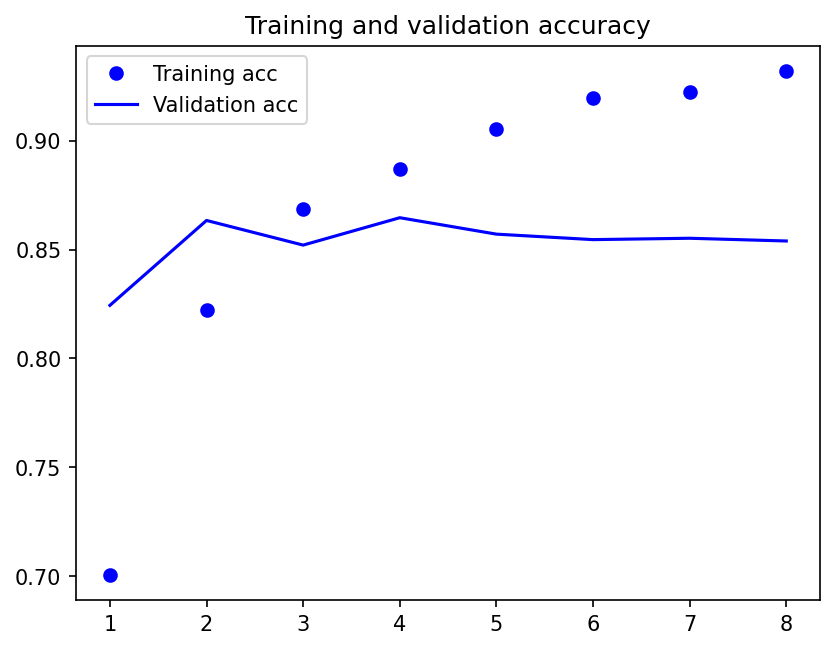

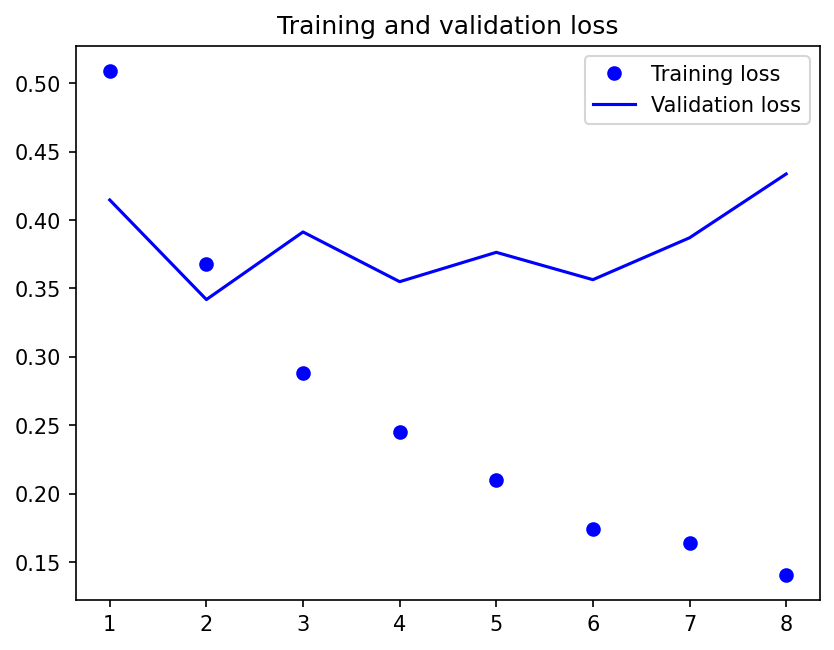

In [26]:
plot1(history)

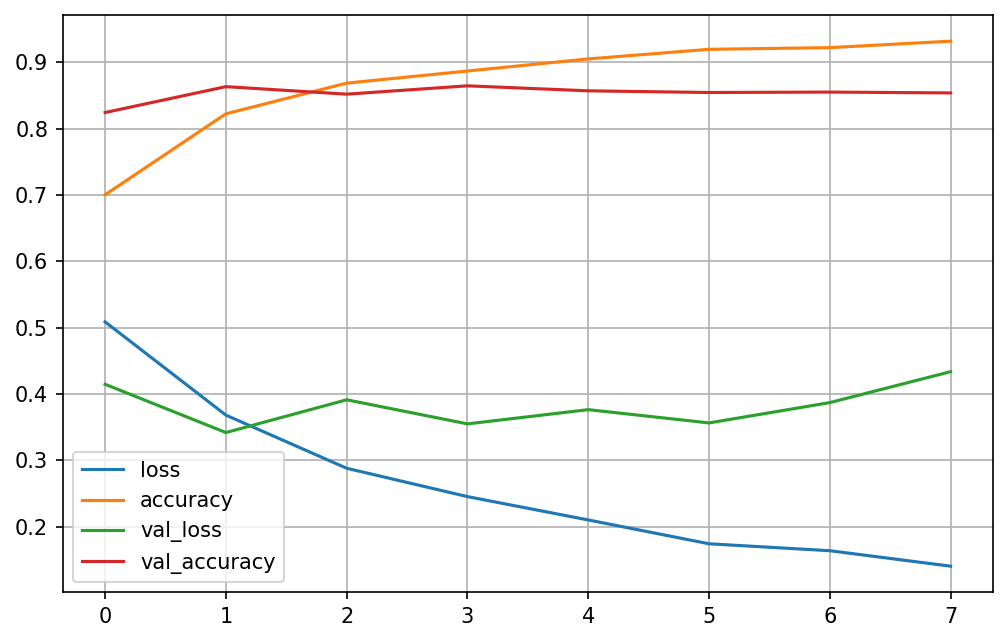

In [27]:
plot2(history)

## Evaluate model

In [28]:
bert_model.evaluate(ds_test_encoded,
                    batch_size=batch_size)

199/199 [==============================] - 7s 33ms/step - loss: 0.4337 - accuracy: 0.8540


[0.43368321657180786, 0.853996217250824]

In [29]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size=batch_size)

199/199 [==============================] - 26s 63ms/step


In [30]:
y_pred = y_test_pred[0].argmax(axis=1)
y_test = np.array(test_labels)

## Check results

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       556
           1       0.88      0.90      0.89      1033

    accuracy                           0.85      1589
   macro avg       0.84      0.83      0.84      1589
weighted avg       0.85      0.85      0.85      1589



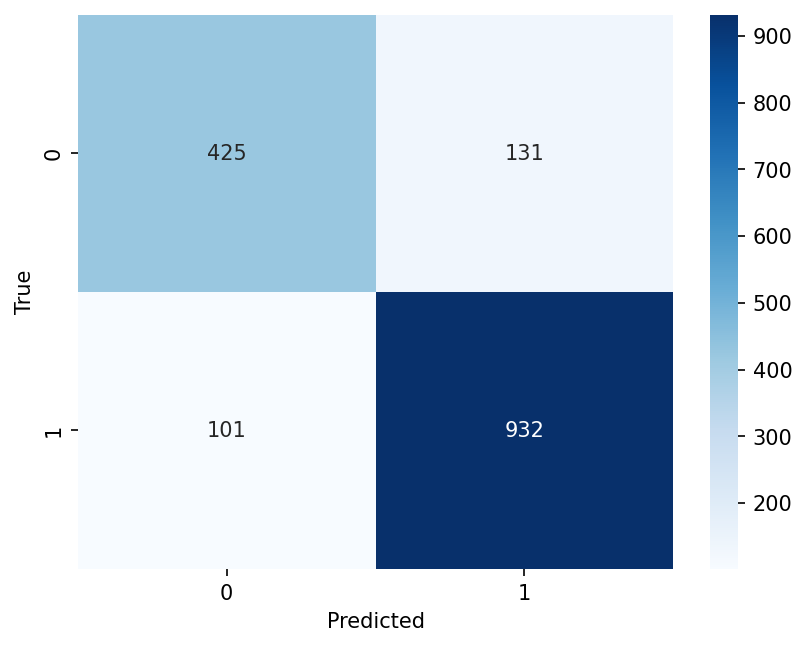

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- The BERT model shows a good balance between precision and recall for both classes, this might be due to the class imbalance handling.
- Overall, an accuracy of 85% and an f1 score of 0.85 indicate that the model is performing well on the task of gender prediction based on names.

# LSTM Approach

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

## Preparing the LSTM input

We tokenize the names, by assigining integers to each letter. Converting them into sequences

In [34]:
# Initialize the tokenizer
tokenizer = Tokenizer(char_level=True, lower=True)

# Fit the tokenizer on the training names
tokenizer.fit_on_texts(train_names)

In [35]:
# Convert names to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_names)
test_sequences = tokenizer.texts_to_sequences(test_names)

In [55]:
train_names[12]

'derk'

In [56]:
train_sequences[12]

[10, 2, 5, 18]

We retrieve the max length of names, and make it so that all the sequences have the same length

In [38]:
# Define maximum length for padding
max_length = max(len(seq) for seq in train_sequences)

# Pad the sequences to ensure all are of the same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [40]:
# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

## Model

Now we define the model

1. An embedding layer that converts the integer sequences we defined before, into dense vectors of fixed size. The input is the number of unique characters in the tokenizer, plus one for padding. Also, with ``` input_length=max_length ``` we make sure all vectors are the same size.
2. An LSTM layer with 100 units.
3. Dropout of 0.5 to prevent overfitting
4. A sigmoid activation function as output, which will shows the probability of a name being male or female

In [39]:
# Define the model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_length))
lstm_model.add(LSTM(units=100, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 50)            1500      
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 62001 (242.19 KB)
Trainable params: 62001 (242.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Train the model
history = lstm_model.fit(train_padded,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_padded, test_labels),
                    class_weight=class_weights)

Epoch 1/10
199/199 [==============================] - 7s 27ms/step - loss: 0.3573 - accuracy: 0.8104 - val_loss: 0.4072 - val_accuracy: 0.8099
Epoch 2/10
199/199 [==============================] - 5s 23ms/step - loss: 0.3516 - accuracy: 0.8113 - val_loss: 0.4482 - val_accuracy: 0.7791
Epoch 3/10
199/199 [==============================] - 6s 30ms/step - loss: 0.3546 - accuracy: 0.8120 - val_loss: 0.4348 - val_accuracy: 0.7885
Epoch 4/10
199/199 [==============================] - 5s 23ms/step - loss: 0.3463 - accuracy: 0.8183 - val_loss: 0.4139 - val_accuracy: 0.8024
Epoch 5/10
199/199 [==============================] - 9s 46ms/step - loss: 0.3482 - accuracy: 0.8124 - val_loss: 0.4111 - val_accuracy: 0.8018
Epoch 6/10
199/199 [==============================] - 11s 54ms/step - loss: 0.3409 - accuracy: 0.8176 - val_loss: 0.4361 - val_accuracy: 0.7923
Epoch 7/10
199/199 [==============================] - 12s 60ms/step - loss: 0.3365 - accuracy: 0.8212 - val_loss: 0.4406 - val_accuracy: 0.80

## Evaluate model

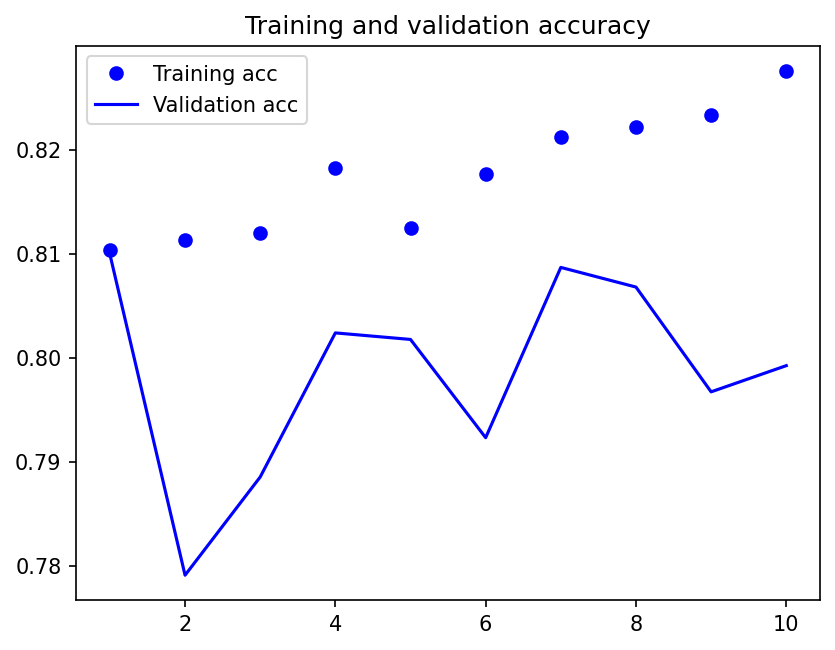

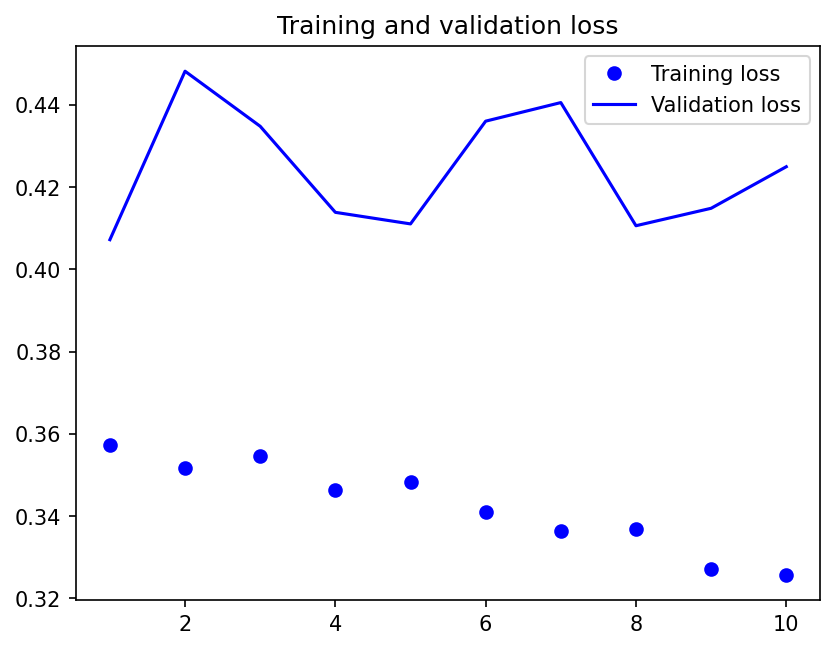

In [43]:
plot1(history)

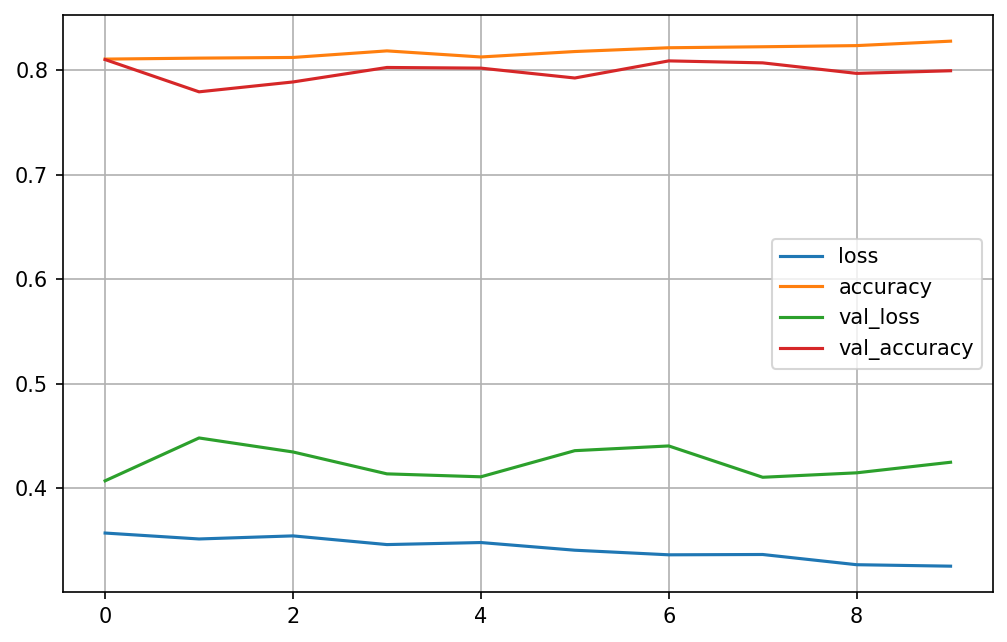

In [44]:
plot2(history)

In [45]:
test_pred = model.predict(test_padded)

50/50 [==============================] - 1s 7ms/step


In [46]:
print(classification_report(test_labels, test_pred.round()))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       556
           1       0.87      0.82      0.84      1033

    accuracy                           0.80      1589
   macro avg       0.78      0.79      0.78      1589
weighted avg       0.81      0.80      0.80      1589



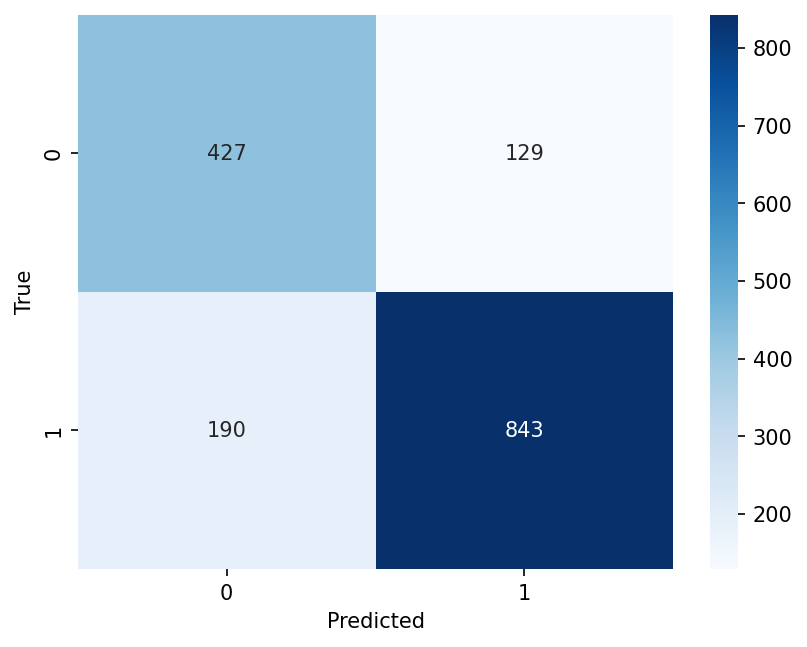

In [47]:
cm = confusion_matrix(test_labels, test_pred.round())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy is good, standing at 80%, however, it is lower than the BERT model

# Conclusions

- Training the BERT model took significantly more time than training the LSTM model. It required more resources to fine-tune the pre-trained weights.

- Although BERT achieved a higher accuracy, the improvement definetly came at a cost of increased training time and computational resources.

- BERT is designed to understand rich contextual information from large texts, however here, it was applaied to a simpler task which classifying names by gender, and here the data lacks that exstensive context and it only consists of names.

- LSTM is not pretrained, and it can be trained from scratch by using a simple character-level tokenization, and it still achieved a respectable 80% accuracy.